<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [4]:
%matplotlib inline
import numpy
import numpy.fft as fft
import matplotlib.pyplot as plt

# Spectral Methods

## Discrete Fourier Transform

Let $y_n$ with $n=1, \ldots, N$ be a sequence of $N$ possibly complex values.  The *discrete Fourier transform* (DFT) of this sequence is the sequence $Y_m$ with $m=1,\ldots, N$ where
$$
    Y_m = \sum^N_{n=1} y_n e^{-2 \pi i(m - 1)(n - 1) / N}
$$
and with the inverse transform
$$
    y_n = \frac{1}{N} \sum^N_{m=1} Y_m e^{2 \pi i (m - 1) (n - 1) / N}.
$$
The uses of the DFT ranges from highly (spectrally) accurate numerical differentiation to time series analysis, filtering, and quadrature.  

Direct use of these formulas would require $\mathcal{O}(N^2)$ operations to perform a transform.  If however $N = 2^k$ for some $k \in \mathbb{Z^+}$ one of the wonders of modern computing, the fast Fourier transform (FFT) can be used requiring $\mathcal{O}(N \log N)$ operations instead.  This can be generalized (by dividing the domain into the appropriate number of points) without general loss of speed.  Due to the ubiquity of the FFT most people will use FFT in place of the DFT when describing approaches.

### Relation to Fourier Analysis

The perspective we will take is that of a means for reconstructing/deconstructing periodic functions $y(x)$ of some wave-length $L$, based on its values at the discrete set of $N$ equally spaced points
$$
    x_n = (n-1) L / N.
$$

Consider the Fourier coefficients of our function $y(x)$,
$$
    \hat{y}_M = \frac{1}{L} \int^L_0 y(x) \exp(-i k(M) x) dx, ~~~ M = 0, \pm 1, \pm 2, \ldots
$$
where the wave number associated with the Fourier coefficient $M$ is
$$
    k(M) = \frac{2 \pi M}{L}.
$$
From these coefficients we can reconstruct the function $y(x)$ as
$$
    y(x) = \sum^\infty_{M=-\infty} \hat{y}_M \exp(i k(M) x).
$$

Recall that we know that the coefficients $\hat{y}_M \rightarrow 0$ as $M \rightarrow 0$.  In particular if $y(x) \in C^R$ over the entire interval $[0, L]$ then the Fourier coefficients decay as $\mathcal{O}(|M|^{-(R + 1)})$.

To connect the DFT coefficients $Y_m$ and the Fourier coefficients $\hat{y}_m$ we can approximate the integral above via a Riemann sum to find
$$\begin{aligned}
    \hat{y}_M &\approx \frac{1}{L} \sum^N_{n=1} y(x_n) \exp(-i k(M) x_n) \Delta x\\
    &= \frac{1}{N} \sum^N_{n=1} y(x_n) \exp(-i [2 \pi M / L] [(n - 1) L / N]) \\
    &= Y_m / N
\end{aligned}$$
where
$$
    m = \mod(M, N) + 1, ~~~ 1 \leq m \leq N.
$$
Now to fully reconstruct the approximation we take $m=1,2,\ldots,N$ and a sequence of wave numbers 
$$
    M_m = 0, 1, 2, \ldots, N / 2 - 1, - N / 2, \ldots, -1,
$$
and a corresponding sequence of wavenumbers $k_m = k(M_m) = 2 \pi M_m / L$ to find
$$\begin{aligned}
    \hat{y}_M &\approx \frac{Y_m}{N} \\
    y(x) &\approx y_N(x) = \sum^{N/2 - 1}_{M=-N/2} \frac{Y_m}{N} \exp(i k(M) x) = \sum^{N}_{m=1} \frac{Y_m}{N} \exp(i k_m x)
\end{aligned}$$

For the examples below observe how fast the coefficients of the FFT fall off for various types of functions.
1. Square wave, $C^0$ with coefficients falling off as $\mathcal{O}(|M|^{-1})$. Exact $\hat{y}_M = -2 i / (\pi M), M$ odd.
1. Saw tooth wave, $C^1$ with coefficients falling off as $\mathcal{O}(|M|^{-2})$. Exact $\hat{y}_M = 2 / (\pi M)^2, M$ odd.
1. Function $(1-0.6 \cos(2 \pi x / L))^{-1}$, $C^\infty$ with coefficients falling off *spectrally* (beyond any algebraic order).  Exact $\hat{y}_M = 1.25 \cdot 3^{-|M|}$.

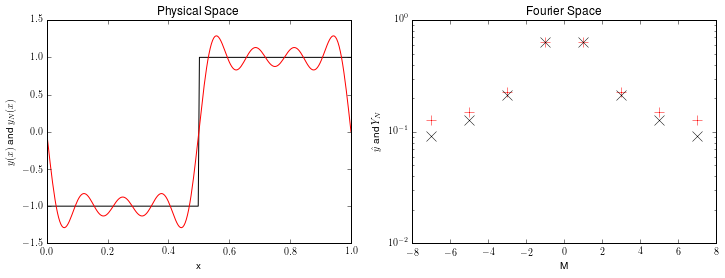

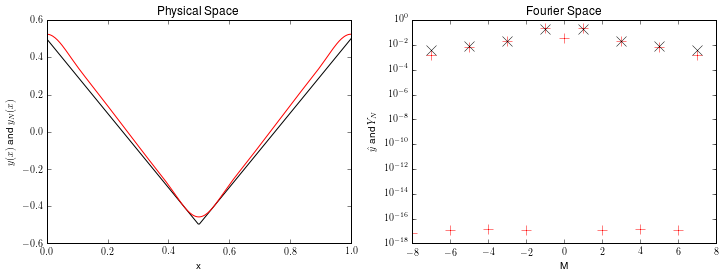

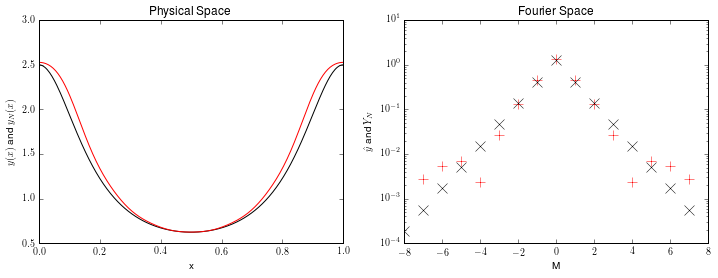

In [228]:
L = 1.0
N = 2**4
x = numpy.linspace(0.0, L, N)
x_fine = numpy.linspace(0.0, L, 2**8)
M = fft.fftfreq(N, 1.0 / N)
M_odd = M[numpy.nonzero(numpy.ravel(numpy.mod(M, 2)))]
k = 2.0 * numpy.pi * M / L

y = [lambda x: numpy.sign(x - 0.5),
     lambda x: numpy.abs(2.0 * x - 1.0) - 0.5,
     lambda x: 1.0 / (1.0 - 0.6 * numpy.cos(2.0 * numpy.pi / L * x))]
y_hat = [lambda M:-2.0j / (numpy.pi * M),
         lambda M:2.0 / (numpy.pi * M)**2,
         lambda M:1.25 * 3.0**(-numpy.abs(M))]
    
for (i, y) in enumerate(y):
    Y = fft.fft(y(x))
    y_inv = numpy.zeros(x_fine.shape[0])
    for m in xrange(N):
        y_inv += ((Y[m] / N) * numpy.exp(1.0j * k[m] * (x_fine - 1.0 / (2.0 * N)))).real

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth() * 2)
    axes = fig.add_subplot(1, 2, 1)
    axes.plot(x_fine, y(x_fine), 'k')
    axes.plot(x_fine, y_inv,'r')
    axes.set_xlabel("x")
    axes.set_ylabel("$y(x)$ and $y_N(x)$")
    axes.set_title("Physical Space")

    axes = fig.add_subplot(1, 2, 2)
    axes.semilogy(M, numpy.abs(Y) / N, '+r', markersize=10)
    if i != 2:
        axes.semilogy(M_odd, numpy.abs(y_hat[i](M_odd)) , 'xk', markersize=10)
    else:
        axes.semilogy(M, numpy.abs((y_hat[i](M))), 'xk', markersize=10)
    axes.set_xlabel("M")
    axes.set_ylabel("$\hat{y}$ and $Y_N$")
    axes.set_title("Fourier Space")

plt.show()

Practically speaking then we can say that the smoother the function the fewer Fourier coefficients we need to have hanging around in order for us to approximate the functions $y(x)$.

### Properties of the DFT

Let $\mathbf{y}$ be a vector of gridpoint values $y_i$, the the DFT and inverse DFT can be written as matrix operators
$$
    \mathbf{Y} = DFT(\mathbf{y}) = N^{1/2} \mathbf{F} \mathbf{y} \\
    \mathbf{y} = DFT^{-1}(\mathbf{Y}) = N^{1/2} \mathbf{F}^\ast \mathbf{Y}.
$$
Here $\mathbf{Y}$ is the DFT of $\mathbf{y}$,
$$
    F_{mn} = N^{-1/2} \exp(-2 \pi i (m - 1)(n - 1)),
$$
and $\mathbf{F}^\ast$ is the conjugate transpose of $\mathbf{F}$.

From this we can also derive *Parseval's identity*
$$\begin{aligned}
    \sum^N_{m=1} \frac{|Y^2_m|}{N} &= \frac{\mathbf{Y}^\ast \mathbf{Y}}{N} \\
    &= \mathbf{y}^\ast \mathbf{F}^\ast \mathbf{F} \mathbf{y} \\
    &= \mathbf{y}^\ast \mathbf{y} \\
    &= \sum^N_{n=1} |y^2_n|
\end{aligned}$$
using the fact that $\mathbf{F}$ is a unitary matrix (i.e. $\mathbf{F}^\ast \mathbf{F} = \mathbf{F} \mathbf{F}^\ast = \mathbf{I}$.

The DFT also obeys the convolution theorem so that
$$
    DFT(w \ast y) = W_m Y_m
$$
where
$$
    (w \ast y)_n = \sum^N_{p=1} w_p y_{n-p}
$$
is the convolution of $w$ and $y$.

**Theorem** Smoothness of a function and decay of its Fourier coefficients.

Let $u \in L^2(\mathbb R)$ have a Fourier transform $\hat{u}$, then
1. If $u$ has $p-1$ continuous derivatives in $L^2(\mathbb R)$ for some $p \geq 0$ and a $p$th derivative of bounded variation then
$$
    \hat{u}(k) = \mathcal{O}(|k|^{-p-1} ) ~~~~ \text{as} ~~~~ |k| \rightarrow \infty.
$$
1. If $u$ ahs infinitely many continuous derivatives in $L^2(\mathbb R)$ then
$$
    \hat{u}(k) = \mathcal{O}(|k|^{-p-1} ) ~~~~ \text{as} ~~~~ |k| \rightarrow \infty
$$
for every $m \geq 0$, this is also known as *spectral* convergence.  The converge of this statement also holds.
1. If there exists a $a, c > 0$ such that $u$ can be extended to an analytic function in the complex strip $|\Im(z)| < a$ with $\| u(\cdot + i y) \| \leq c$ uniformly for all $y \in (-a, a)$, where $\| u(\cdot + i y) \|$ is the $L^2$ norm along the horizontal line $\Im(z) = y$, then $u_a(k) \in L^2(\mathbb R)$, where $u_a(k) = e^{a |k|} \hat{u}(k)$.  The converse also holds.
1. If $u$ can be extended to an entire function (i.e. analytic throughout the complex plane) and there exists $a > 0$ such that $|u(z)| = \mathcal{O}(e^{a|z|})$ as $z \rightarrow \infty$ for all complex values $z \in \mathbb C$ then $\hat{u}$ has compact support contained in $[-a, a]$.  The converse also holds

### Differentiation

Recall that the Fourier transform of a derivative turns the derivative into an algebraic expression:
$$
    \hat{u_x} = i \xi \hat{u}.
$$
We can exploit this in the discrete case as well.

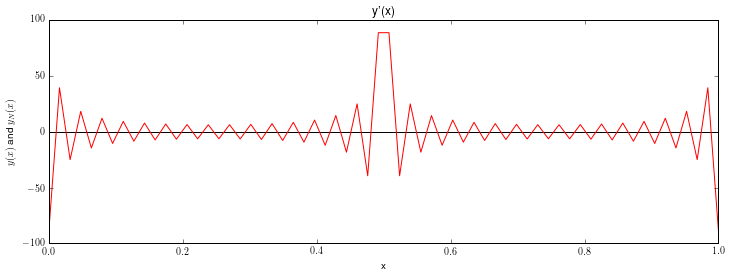

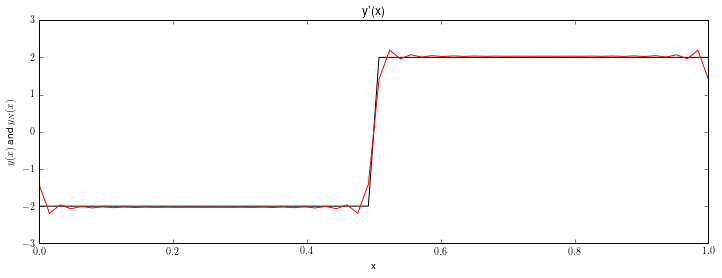

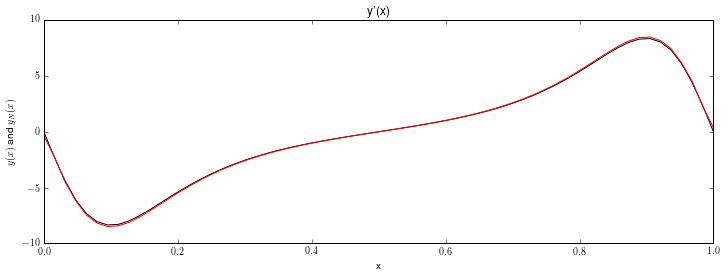

In [250]:
L = 1.0
N = 2**6
x = numpy.linspace(0.0, L, N)
M = fft.fftfreq(N, 1.0 / N)
M_odd = M[numpy.nonzero(numpy.ravel(numpy.mod(M, 2)))]
k = 2.0 * numpy.pi * M / L

y_funcs = [lambda x: numpy.sign(x - 0.5),
           lambda x: numpy.abs(2.0 * x - 1.0) - 0.5,
           lambda x: 1.0 / (1.0 - 0.6 * numpy.cos(2.0 * numpy.pi / L * x))]
y_prime_funcs = [lambda x: numpy.zeros(x.shape[0]),
                 lambda x: 2.0 * numpy.sign(x - 0.5),
                 lambda x: -1.2 * numpy.pi / L * numpy.sin(2.0 * numpy.pi / L * x) / (1.0 - 0.6 * numpy.cos(2.0 * numpy.pi / L * x))**2]

for (i, y) in enumerate(y_funcs):
    Y = fft.fft(y(x))
    y_prime = fft.ifft(1.0j * k * Y).real

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth() * 2)
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x, y_prime_funcs[i](x), 'k')
    axes.plot(x, y_prime,'r')
    axes.set_xlabel("x")
    axes.set_ylabel("$y(x)$ and $y_N(x)$")
    axes.set_title("y'(x)")

plt.show()

We can also write this operation as a matrix operation (assuming a periodic function):
$$\begin{aligned}
    y'(x) \approx N^{-1/2} \mathbf{F}^\ast i \mathbf{K} \mathbf{Y} = N^{-1/2} \mathbf{F}^\ast i \mathbf{K} N^{1/2} \mathbf{F} \mathbf{y} = \mathbf{D} \mathbf{y}
\end{aligned}$$
where $D \equiv \mathbf{F}^\ast (i \mathbf{K}) \mathbf{F}$ is the *Fourier pseudospectral differentiation matrix*.  It is real, dense, anti-symmetric, and $N \times N$.  The matrix $\mathbf{K} \equiv diag(\mathbf{k})$.

Also, due to $\mathbf{F}$ being unitary, we can compose multiple derivatives by simply applying the matrix multiple time to find the $p$th derivative.
$$
    D^p = (\mathbf{F}^\ast i \mathbf{K} \mathbf{F})^p = \mathbf{F}^\ast (i \mathbf{K})^p \mathbf{F}
$$

In [ ]:
# Use differentiation matrix to perform derivatives



## FFT-Based Poisson Solvers

## Chebyshev Spectral Methods

### Chebyshev interpolation

### Chebyshev Differentiation

## Eigenvalue Problems

## Spectral Quadrature

## Wavelets